# Autoencoder Keras

[reference](https://blog.keras.io/building-autoencoders-in-keras.html)

# I. Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from keras.datasets import mnist
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers

%matplotlib inline

Using TensorFlow backend.


# 2. Data Preprocess

## 2.1. Load data

In [3]:
#Loading the MNIST data
(X_train_orig, y_train_orig), (X_test, y_test) = mnist.load_data()
all_data = np.concatenate((X_train_orig, X_test))
all_data.shape

(70000, 28, 28)

In [4]:
# all_data[0]

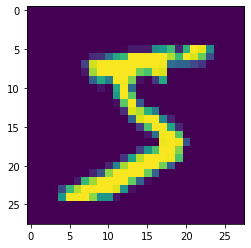

In [5]:
plt.imshow(X_train_orig[0])

## 2.2. Normalize data

In [6]:
# Normalizing the RGB codes by dividing it to the max RGB value.
max_value = float(X_train_orig.max())
print(max_value)

X_train = X_train_orig.astype(np.float32) / max_value
X_test = X_test.astype(np.float32) / max_value

# Train and validation split
X_train, X_valid = X_train[:-7000], X_train[-7000:]
X_train.shape, X_valid.shape

255.0


((53000, 28, 28), (7000, 28, 28))

## 2.3. Reshape data

In [7]:
# Reshape data
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

In [8]:
X_train.shape, X_test.shape

((53000, 784), (10000, 784))

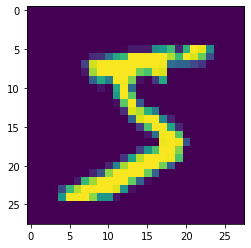

In [9]:
plt.imshow(X_train[0].reshape(28,28))
# print(X_train[0])

In [10]:
# Test flatten
input0_flatten = keras.layers.Flatten()(X_train[0])

In [11]:
input0_flatten.shape

TensorShape([784, 1])

# 3. Visualization

## 3.1. Plot Images

In [12]:
# Helper function to show images
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    

#Displays the original images and their reconstructions    
def show_reconstructions(model, images=X_valid, flatten=True, n_images=10):
    x_test = images[:n_images]
    if flatten:
        x_test = [np.reshape(img, (784,)) for img in x_test]
    reconstructions = x_test.copy()
    
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        if flatten:
            img_src = x_test[image_index].reshape(28,28)
        else:
            img_src = x_test[image_index]
        plot_image(img_src)
        plt.subplot(2, n_images, 1 + n_images + image_index)
        img_pred = reconstructions[image_index].reshape(28,28)
        plot_image(img_pred)
#         plot_image(reconstructions[image_index])

## 3.2. Plot 'loss' and 'accuracy'

In [66]:
def plot_loss(train_loss, val_loss):
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.title('Traning & Validation Loss')
    
def plot_acc(train_acc, val_acc):
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.legend(['Training Acc', 'Validation Acc'])
    plt.title('Training & Validation Accuracy')

# 4. Build simplest AE

In [17]:
# this is the size of our encoded representations
encoding_dim = 32 # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is out placeholder
input_img = Input(shape=(784,))

# 'encoded' is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)

# step 2: add a Dense Layer a L1 activity regularizer
# encoded = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_img)

# 'decoded' is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this is model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

**let's also create a separate encoder model**

In [18]:
encoder = Model(input_img, encoded)

**Let's create the decoder model**

In [19]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

**Now let's train our autoencoder to reconstruct MNIST digits.**

In [20]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_test, X_test))

Train on 53000 samples, validate on 10000 samples
Epoch 1/50
53000/53000 [==============================] - 2s 29us/step - loss: 0.3704 - val_loss: 0.2728
Epoch 2/50
53000/53000 [==============================] - 1s 27us/step - loss: 0.2669 - val_loss: 0.2577
Epoch 3/50
53000/53000 [==============================] - 1s 27us/step - loss: 0.2482 - val_loss: 0.2362
Epoch 4/50
53000/53000 [==============================] - 1s 27us/step - loss: 0.2286 - val_loss: 0.2193
Epoch 5/50
53000/53000 [==============================] - 1s 27us/step - loss: 0.2142 - val_loss: 0.2069
Epoch 6/50
53000/53000 [==============================] - 1s 27us/step - loss: 0.2031 - val_loss: 0.1971
Epoch 7/50
53000/53000 [==============================] - 1s 27us/step - loss: 0.1941 - val_loss: 0.1889
Epoch 8/50
53000/53000 [==============================] - 1s 27us/step - loss: 0.1868 - val_loss: 0.1823
Epoch 9/50
53000/53000 [==============================] - 1s 27us/step - loss: 0.1808 - val_loss: 0.1771
Epoch

Predict encoded and decoded images using encoder and decoder

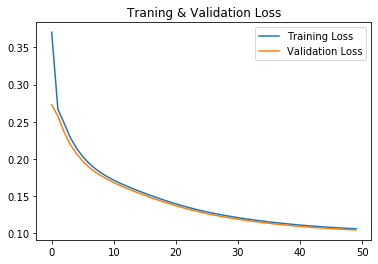

In [35]:
# len(autoencoder.history.history['loss']), len(autoencoder.history.history['val_loss'])
train_loss = autoencoder.history.history['loss']
val_loss = autoencoder.history.history['val_loss']
plot_loss(train_loss, val_loss)

In [36]:
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)
decoded_imgs_new = autoencoder.predict(X_test)

In [37]:
img = decoded_imgs[0] - decoded_imgs_new[0]
# plt.imshow(encoded_imgs[0].reshape(28,28))
# print(encoded_imgs[0].reshape(28,28))

In [38]:
img.shape

(784,)

In [39]:
image0_decoded = decoded_imgs[0] # *max_value

In [40]:
image0_decoded = np.round(image0_decoded)

In [41]:
# image0_decoded

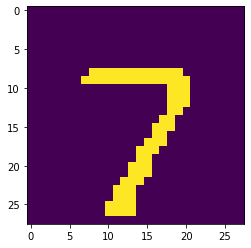

In [42]:
plt.imshow(image0_decoded.reshape(28,28))

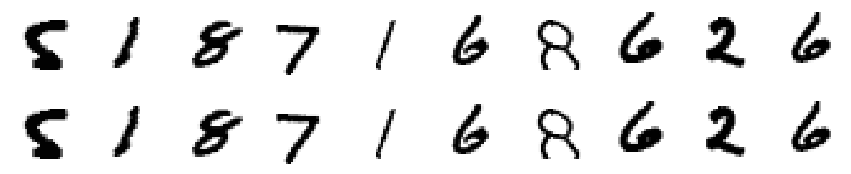

In [43]:
# plt.imshow((image0_decoded*255.0).reshape(28,28))
show_reconstructions(model=autoencoder, flatten=True, n_images=10)

In [44]:
encoder.get_weights()[0].shape, encoder.get_weights()[1].shape

((784, 32), (32,))

In [45]:
encoded

<tf.Tensor 'dense_3/Relu:0' shape=(None, 32) dtype=float32>

In [46]:
encoder

In [47]:
decoded

<tf.Tensor 'dense_4/Sigmoid:0' shape=(None, 784) dtype=float32>

In [48]:
decoder

In [49]:
autoencoder

In [50]:
autoencoder.get_weights()[0].shape, autoencoder.get_weights()[1].shape, autoencoder.get_weights()[2].shape, autoencoder.get_weights()[3].shape

((784, 32), (32,), (32, 784), (784,))

In [51]:
autoencoder.summary(), encoder.summary(), decoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_4 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                25120     
Total params: 25,120
Trainable params:

(None, None, None)

# 5. Stacked AE

## 5.1. Sample SAE

In [52]:
#Stacked Autoencoder with functional model
#encoder
inputs = keras.Input(shape=(784,))
lr_flatten = keras.layers.Flatten()(inputs)
lr1 = keras.layers.Dense(392, activation="selu")(lr_flatten)
lr2 = keras.layers.Dense(196, activation="selu")(lr1)#decoder
lr3 = keras.layers.Dense(392, activation="selu")(lr2)
lr4 = keras.layers.Dense(28 * 28, activation="sigmoid")(lr3)
outputs = keras.layers.Reshape([784,])(lr4)
stacked_ae = keras.models.Model(inputs,outputs)
stacked_ae.compile(loss="binary_crossentropy",optimizer=keras.optimizers.SGD(lr=1.5))
stacked_ae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 392)               307720    
_________________________________________________________________
dense_1 (Dense)              (None, 196)               77028     
_________________________________________________________________
dense_2 (Dense)              (None, 392)               77224     
_________________________________________________________________
dense_3 (Dense)              (None, 784)               308112    
_________________________________________________________________
reshape (Reshape)            (None, 784)               0     

In [53]:
stacked_ae.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_test, X_test))

Train on 53000 samples, validate on 10000 samples
Epoch 1/50
53000/53000 [==============================] - 2s 42us/sample - loss: 0.2345 - val_loss: 0.1868
Epoch 2/50
53000/53000 [==============================] - 2s 35us/sample - loss: 0.1583 - val_loss: 0.1516
Epoch 3/50
53000/53000 [==============================] - 2s 35us/sample - loss: 0.1335 - val_loss: 0.1442
Epoch 4/50
53000/53000 [==============================] - 2s 35us/sample - loss: 0.1200 - val_loss: 0.1174
Epoch 5/50
53000/53000 [==============================] - 2s 35us/sample - loss: 0.1107 - val_loss: 0.1177
Epoch 6/50
53000/53000 [==============================] - 2s 35us/sample - loss: 0.1042 - val_loss: 0.1069
Epoch 7/50
53000/53000 [==============================] - 2s 35us/sample - loss: 0.0997 - val_loss: 0.1040
Epoch 8/50
53000/53000 [==============================] - 2s 35us/sample - loss: 0.0961 - val_loss: 0.1010
Epoch 9/50
53000/53000 [==============================] - 2s 35us/sample - loss: 0.0935 - val_

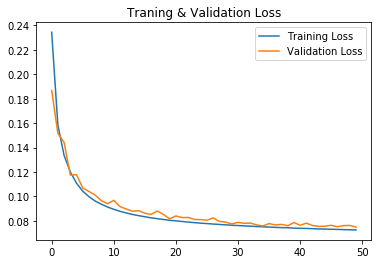

In [54]:
# Plot loss
stacked_train_loss = stacked_ae.history.history['loss']
stacked_val_loss = stacked_ae.history.history['val_loss']
plot_loss(stacked_train_loss, stacked_val_loss)

In [55]:
stacked_decoded_imgs = stacked_ae.predict(X_test)

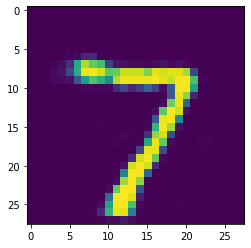

In [56]:
plt.imshow(stacked_decoded_imgs[0].reshape(28,28))

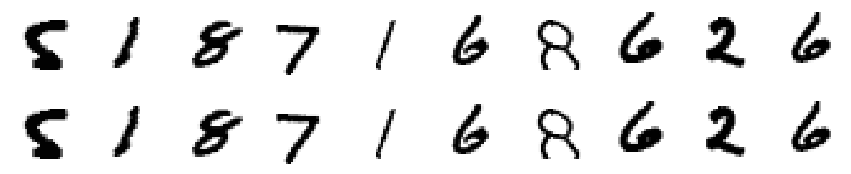

In [57]:
show_reconstructions(model=stacked_ae, flatten=True, n_images=10)

## 5.2. Edited SAE

In [58]:
# #Stacked Autoencoder with functional model
# #encoder
# img_dim = 784
# encoded_dim_l1 = 392
# encoded_dim_l2 = 196
# encoed_dim_l3 = 32


# # define input


# inputs = keras.Input(shape=(784,))

# lr_flatten = keras.layers.Flatten()(inputs)

# # first hidden lay

# lr1_encoded = keras.layers.Dense(392, activation="selu")(lr_flatten)
# lr1_hidden = keras.layers.
# lr2 = keras.layers.Dense(196, activation="selu")(lr1)#decoder
# lr3 = keras.layers.Dense(392, activation="selu")(lr2)
# lr4 = keras.layers.Dense(28 * 28, activation="sigmoid")(lr3)
# outputs = keras.layers.Reshape([784,])(lr4)
# stacked_ae = keras.models.Model(inputs,outputs)
# stacked_ae.compile(loss="binary_crossentropy",optimizer=keras.optimizers.SGD(lr=1.5))
# stacked_ae.summary()

# 6. Deep AE

In [59]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

In [ ]:
# # define encoder and decoder
# encoder = Model(imput_img, encoded)
# decoder = Model(encoded, decoded)

In [ ]:
# # create a placeholder for an encoded (32-dimensional) input
# encoded_input = Input(shape=(encoding_dim,))

# # retrieve the last layer of the autoencoder model
# decoder_layer = autoencoder.layers[-1]

# # create the decoder model
# decoder = Model(encoded_input, decoder_layer(encoded_input))

In [61]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))

Train on 53000 samples, validate on 10000 samples
Epoch 1/100
53000/53000 [==============================] - 3s 53us/step - loss: 0.3475 - val_loss: 0.2725
Epoch 2/100
53000/53000 [==============================] - 3s 49us/step - loss: 0.2585 - val_loss: 0.2602
Epoch 3/100
53000/53000 [==============================] - 3s 49us/step - loss: 0.2380 - val_loss: 0.2363
Epoch 4/100
53000/53000 [==============================] - 3s 49us/step - loss: 0.2236 - val_loss: 0.2188
Epoch 5/100
53000/53000 [==============================] - 3s 49us/step - loss: 0.2103 - val_loss: 0.2071
Epoch 6/100
53000/53000 [==============================] - 3s 49us/step - loss: 0.1942 - val_loss: 0.1932
Epoch 7/100
53000/53000 [==============================] - 3s 49us/step - loss: 0.1859 - val_loss: 0.1840
Epoch 8/100
53000/53000 [==============================] - 3s 49us/step - loss: 0.1801 - val_loss: 0.1800
Epoch 9/100
53000/53000 [==============================] - 3s 48us/step - loss: 0.1746 - val_loss: 0.1

53000/53000 [==============================] - 3s 48us/step - loss: 0.1048 - val_loss: 0.1088
Epoch 78/100
53000/53000 [==============================] - 3s 49us/step - loss: 0.1045 - val_loss: 0.1073
Epoch 79/100
53000/53000 [==============================] - 3s 49us/step - loss: 0.1045 - val_loss: 0.1047
Epoch 80/100
53000/53000 [==============================] - 3s 48us/step - loss: 0.1041 - val_loss: 0.1086
Epoch 81/100
53000/53000 [==============================] - 3s 49us/step - loss: 0.1039 - val_loss: 0.1078
Epoch 82/100
53000/53000 [==============================] - 3s 49us/step - loss: 0.1037 - val_loss: 0.1062
Epoch 83/100
53000/53000 [==============================] - 3s 49us/step - loss: 0.1036 - val_loss: 0.1067
Epoch 84/100
53000/53000 [==============================] - 3s 49us/step - loss: 0.1034 - val_loss: 0.1059
Epoch 85/100
53000/53000 [==============================] - 3s 49us/step - loss: 0.1032 - val_loss: 0.1083
Epoch 86/100
53000/53000 [========================

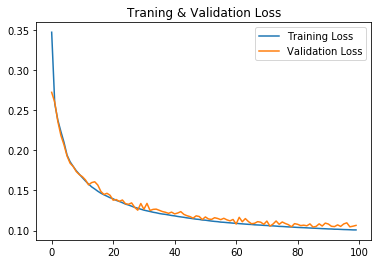

In [62]:
train_loss = autoencoder.history.history['loss']
val_loss = autoencoder.history.history['val_loss']
plot_loss(train_loss, val_loss)

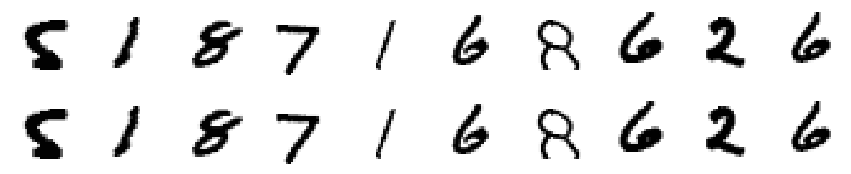

In [64]:
# show reconstructions
show_reconstructions(model=autoencoder, flatten=True, n_images=10)

# 7. Convolutional AE

Xem lại một chút về CNN, sau đó quay lại code CVAE